## Load and prepare the data

This notebook uses the scikit-learn library (http://http://scikit-learn.org/) to perform classification based on EC and FC.
Two classifiers are compared:
- the multinomial regressor with standard scaling as an additional preprocessing step,
- the k nearest neighbor classifier with k=1.

In [1]:
import numpy as np
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.preprocessing as sprp
import sklearn.pipeline as spp
import matplotlib.pyplot as pp


# load EC matrices
n_sub = 22
n_run = 5
N = 66

try:
    EC = np.load('model_param/J_mod.npy')
    mask_EC = np.load('model_param/mask_EC.npy')
    corrFC = np.load('model_param/FC_emp.npy')[:,:,0,:,:]
    for i_sub in range(n_sub):
        for i_run in range(n_run):
            corrFC[i_sub,i_run,:,:] /= np.sqrt(np.outer(corrFC[i_sub,i_run,:,:].diagonal(),corrFC[i_sub,i_run,:,:].diagonal()))
    mask_FC = np.tri(N,N,-1,dtype=np.bool)
except:
    print('run the notebook MOUEC_estimation first')

# vectorize matrices
vect_EC = EC[:,:,mask_EC] # only retaining existing connections
vect_FC = corrFC[:,:,mask_FC] # only retaining lower triangle
dim_feature_EC = vect_EC.shape[2] # dimension of vectorized EC
dim_feature_FC = vect_FC.shape[2] # dimension of vectorized EC

    
print('shape of vectorized MOU-EC array:', vect_EC.shape)
print('shape of vectorized corrFC array:', vect_FC.shape)

shape of vectorized MOU-EC array: (22, 5, 1180)
shape of vectorized corrFC array: (22, 5, 2145)


## Subject identification

The samples are divided into a train set and a test set, with 2 runs and 3 runs per subject respectively. The procesure is repeated 20 times (even though the number of splitting of 2 runs out of 5 is less...).

average/std performance MLR+EC 0.8689393939393939 0.13897127951100408
average/std performance 1NN+EC 0.9 0.08682756837511761
average/std performance MLR+corrFC 0.7704545454545454 0.16716694887764605
average/std performance 1NN+corrFC 0.7651515151515152 0.1863389981249825


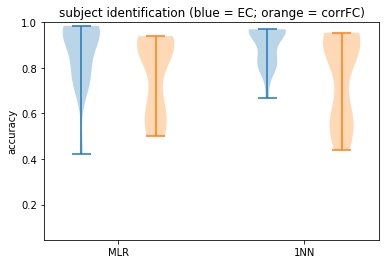

In [2]:
# labels of sessions for classification to identify subject
labels = np.repeat(np.arange(n_sub).reshape([-1,1]), n_run, axis=1)

# classifier and learning parameters
c_MLR = spp.make_pipeline(sprp.StandardScaler(),skllm.LogisticRegression(C=10000, penalty='l2', multi_class='multinomial', solver='lbfgs'))
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

n_rep = 20  # number of repetition of classification procedure
perf = np.zeros([n_rep,2,2]) # record classification performance


# perform classification
for i_rep in range(n_rep):
    # split run indices in train and test sets
    train_labels = np.zeros([n_run],dtype=bool)
    while train_labels.sum()<2:
        train_labels[np.random.randint(n_run)] = True
    test_labels = np.logical_not(train_labels)
    #print('train/test sets:',train_labels,test_labels)
    
    # train and test classifiers with subject labels
    c_MLR.fit(vect_EC[:,train_labels,:].reshape([-1,dim_feature_EC]), labels[:,train_labels].reshape([-1]))
    perf[i_rep,0,0] = c_MLR.score(vect_EC[:,test_labels,:].reshape([-1,dim_feature_EC]), labels[:,test_labels].reshape([-1]))

    c_1NN.fit(vect_EC[:,train_labels,:].reshape([-1,dim_feature_EC]), labels[:,train_labels].reshape([-1]))
    perf[i_rep,1,0] = c_1NN.score(vect_EC[:,test_labels,:].reshape([-1,dim_feature_EC]), labels[:,test_labels].reshape([-1]))

    c_MLR.fit(vect_FC[:,train_labels,:].reshape([-1,dim_feature_FC]), labels[:,train_labels].reshape([-1]))
    perf[i_rep,0,1] = c_MLR.score(vect_FC[:,test_labels,:].reshape([-1,dim_feature_FC]), labels[:,test_labels].reshape([-1]))

    c_1NN.fit(vect_FC[:,train_labels,:].reshape([-1,dim_feature_FC]), labels[:,train_labels].reshape([-1]))
    perf[i_rep,1,1] = c_1NN.score(vect_FC[:,test_labels,:].reshape([-1,dim_feature_FC]), labels[:,test_labels].reshape([-1]))


# report
print('average/std performance MLR+EC',perf[:,0,0].mean(),perf[:,0,0].std())
print('average/std performance 1NN+EC',perf[:,1,0].mean(),perf[:,1,0].std())
print('average/std performance MLR+corrFC',perf[:,0,1].mean(),perf[:,0,1].std())
print('average/std performance 1NN+corrFC',perf[:,1,1].mean(),perf[:,1,1].std())

pp.figure()
pp.violinplot(perf[:,:,0],positions=[-0.2,1-0.2],widths=[0.2]*2)
pp.violinplot(perf[:,:,1],positions=[0.2,1+0.2],widths=[0.2]*2)
pp.axis(xmin=-0.4,xmax=1.4,ymin=1./n_sub,ymax=1)
pp.xticks([0,1],['MLR','1NN'])
pp.ylabel('accuracy')
pp.title('subject identification (blue = EC; orange = corrFC)')
pp.show()

## Condition identification

The samples are divided into a train set and a test set, with 80% and 20% of the subjects respectively. For each subject, all runs are used for either train or test. The procesure is repeated 20 times. First, we consider the discrimination between the rest runs and the movie runs.

average/std performance MLR+EC 0.998 0.008717797887081356
average/std performance 1NN+EC 0.9840000000000002 0.01959591794226544
average/std performance MLR+corrFC 0.986 0.02905167809266789
average/std performance 1NN+corrFC 0.9720000000000001 0.031240998703626618


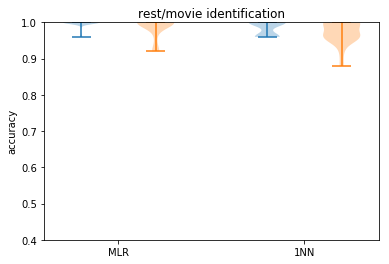

In [3]:
# labels of sessions for classification to discriminate movie versus rest
labels = np.repeat(np.array([0,0,1,1,1],dtype=np.int).reshape([1,-1]), n_sub, axis=0)

# classifier and learning parameters
c_MLR = spp.make_pipeline(sprp.StandardScaler(),skllm.LogisticRegression(C=10000, penalty='l2', multi_class='multinomial', solver='lbfgs'))
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

n_rep = 20  # number of repetition of classification procedure
perf = np.zeros([n_rep,2,2]) # record classification performance


# perform classification
for i_rep in range(n_rep):
    # split run indices in train and test sets
    train_labels = np.ones([n_sub],dtype=bool)
    while train_labels.sum()>n_sub*0.8:
        train_labels[np.random.randint(n_sub)] = False
    test_labels = np.logical_not(train_labels)
    #print('train/test sets:',train_labels,test_labels)
    
    # train and test classifiers with subject labels
    c_MLR.fit(vect_EC[train_labels,:,:].reshape([-1,dim_feature_EC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,0,0] = c_MLR.score(vect_EC[test_labels,:,:].reshape([-1,dim_feature_EC]), labels[test_labels,:].reshape([-1]))

    c_1NN.fit(vect_EC[train_labels,:,:].reshape([-1,dim_feature_EC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,1,0] = c_1NN.score(vect_EC[test_labels,:,:].reshape([-1,dim_feature_EC]), labels[test_labels,:].reshape([-1]))

    c_MLR.fit(vect_FC[train_labels,:,:].reshape([-1,dim_feature_FC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,0,1] = c_MLR.score(vect_FC[test_labels,:,:].reshape([-1,dim_feature_FC]), labels[test_labels,:].reshape([-1]))

    c_1NN.fit(vect_FC[train_labels,:,:].reshape([-1,dim_feature_FC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,1,1] = c_1NN.score(vect_FC[test_labels,:,:].reshape([-1,dim_feature_FC]), labels[test_labels,:].reshape([-1]))


# report
print('average/std performance MLR+EC',perf[:,0,0].mean(),perf[:,0,0].std())
print('average/std performance 1NN+EC',perf[:,1,0].mean(),perf[:,1,0].std())
print('average/std performance MLR+corrFC',perf[:,0,1].mean(),perf[:,0,1].std())
print('average/std performance 1NN+corrFC',perf[:,1,1].mean(),perf[:,1,1].std())

pp.figure()
pp.violinplot(perf[:,:,0],positions=[-0.2,1-0.2],widths=[0.2]*2)
pp.violinplot(perf[:,:,1],positions=[0.2,1+0.2],widths=[0.2]*2)
pp.axis(xmin=-0.4,xmax=1.4,ymin=0.4,ymax=1)
pp.xticks([0,1],['MLR','1NN'])
pp.ylabel('accuracy')
pp.title('rest/movie identification')
pp.show()

Same as above for the discrimination between the 2 rest sessions and the 3 movie sessions individually. This more difficult classification makes sense as the 3 movie sessions correspond to different parts of a movie, and are the same for all subjects. 
Chance level corresponds to predicting always rest, namely 40%.

average/std performance MLR+EC 0.7020000000000001 0.059966657402259795
average/std performance 1NN+EC 0.6040000000000001 0.07031358332498779
average/std performance MLR+corrFC 0.704 0.06621178142898738
average/std performance 1NN+corrFC 0.6060000000000001 0.07296574538781878


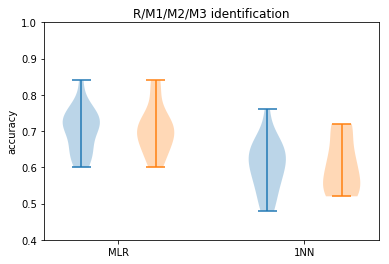

In [4]:
# labels of sessions for classification to identify condition
labels = np.repeat(np.array([0,0,1,2,3],dtype=np.int).reshape([1,-1]), n_sub, axis=0)

# classifier and learning parameters
c_MLR = spp.make_pipeline(sprp.StandardScaler(),skllm.LogisticRegression(C=10000, penalty='l2', multi_class='multinomial', solver='lbfgs'))
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

n_rep = 20  # number of repetition of classification procedure
perf = np.zeros([n_rep,2,2]) # record classification performance (dimensions: MRL/1NN, EC/FC0)


# perform classification
for i_rep in range(n_rep):
    # split run indices in train and test sets
    train_labels = np.ones([n_sub],dtype=bool)
    while train_labels.sum()>n_sub*0.8:
        train_labels[np.random.randint(n_sub)] = False
    test_labels = np.logical_not(train_labels)
    #print('train/test sets:',train_labels,test_labels)
    
    # train and test classifiers with subject labels
    c_MLR.fit(vect_EC[train_labels,:,:].reshape([-1,dim_feature_EC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,0,0] = c_MLR.score(vect_EC[test_labels,:,:].reshape([-1,dim_feature_EC]), labels[test_labels,:].reshape([-1]))

    c_1NN.fit(vect_EC[train_labels,:,:].reshape([-1,dim_feature_EC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,1,0] = c_1NN.score(vect_EC[test_labels,:,:].reshape([-1,dim_feature_EC]), labels[test_labels,:].reshape([-1]))

    c_MLR.fit(vect_FC[train_labels,:,:].reshape([-1,dim_feature_FC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,0,1] = c_MLR.score(vect_FC[test_labels,:,:].reshape([-1,dim_feature_FC]), labels[test_labels,:].reshape([-1]))

    c_1NN.fit(vect_FC[train_labels,:,:].reshape([-1,dim_feature_FC]), labels[train_labels,:].reshape([-1]))
    perf[i_rep,1,1] = c_1NN.score(vect_FC[test_labels,:,:].reshape([-1,dim_feature_FC]), labels[test_labels,:].reshape([-1]))


# report
print('average/std performance MLR+EC',perf[:,0,0].mean(),perf[:,0,0].std())
print('average/std performance 1NN+EC',perf[:,1,0].mean(),perf[:,1,0].std())
print('average/std performance MLR+corrFC',perf[:,0,1].mean(),perf[:,0,1].std())
print('average/std performance 1NN+corrFC',perf[:,1,1].mean(),perf[:,1,1].std())

pp.figure()
pp.violinplot(perf[:,:,0],positions=[-0.2,1-0.2],widths=[0.2]*2)
pp.violinplot(perf[:,:,1],positions=[0.2,1+0.2],widths=[0.2]*2)
pp.axis(xmin=-0.4,xmax=1.4,ymin=0.4,ymax=1)
pp.xticks([0,1],['MLR','1NN'])
pp.ylabel('accuracy')
pp.title('R/M1/M2/M3 identification')
pp.show()